## Source count : photometry with DAOStarFinder

In [80]:
# Demo from 
# http://photutils.readthedocs.io/en/stable/photutils/detection.html
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import datasets, DAOStarFinder, CircularAperture
from astropy.table import Table
import os
import numpy as np

### Demo data ( it works fine ) : 

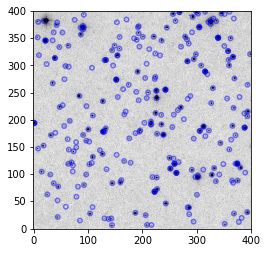

In [2]:
%matplotlib inline
# load the example star field and select its subregion
hdu = datasets.load_star_image()  
data = hdu.data[0:400, 0:400]    
# calculate mean, median , standard deviation of all pixel values in the image 
mean, median, std = sigma_clipped_stats(data, sigma=3.0, iters=5)    
# initialize DAOStarFinder Class instance 
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)    
# find sources using DAOStarFinder,  passing it the 
# image data subtracted by the background 
sources = daofind(data - median)    

# sources have x,y positions, and CircularAperture tools helps to 
# make regions at these positions 
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=4.)
# we normalize the image to make it more presentable ... 
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', norm=norm)
# we overplot the detection apertures ... 
apertures.plot(color='blue', lw=1.5, alpha=0.5)

### NOAO  DECam  data ... x% region

In [338]:
# Read in the DECam - MAF matched data within 30 arcmin for top 1% density...
# This is  a VOTable to keep all string types straight ...

# select the density regime ... 
percent = 0.21  # or 0.06  0.21   0.51
fname = 'table_decam_maf_matched_'+str(percent)+'_density_percent.vo.xml'
decam_maf = Table.read(fname)



### Downloading NOAO data .... 

This table for top 1% data has 91 matches... Pick the first few thatI haven't already downloaded...


In [339]:
outDir = '../raw_data/DECam/'
archive_files = np.array(decam_maf['archive_file'].data).astype(str)
mask = np.in1d(archive_files, os.listdir(outDir))
print('We have not downloaded yet ...')
print(archive_files[~mask][:4])

We have not downloaded yet ...
['tu1668579.fits.fz' 'tu2075030.fits.fz' 'tu1661798.fits.fz'
 'c4d_170122_055542_ooi_g_v1.fits.fz']


In [91]:
# To download few object from this table,  
# save that as votable,  
# and run the NOAO script on it ...
fname = 'decam_maf_'+str(percent)+ '_NOAO_download_votable.vot.xml'
N = 5 # number of fields to download 
decam_maf[~mask][:N].write(fname,format='votable',
                          overwrite=True)

In [95]:
# We run the NOAO script by typing in terminal : 
import subprocess
cmd = './secure_get.sh'+' '+fname
completed1 = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE)
print(completed1.stdout)

# move all the DECam data to a specific directory with raw DECam data ... 
cmd = 'mv *.fz ' + outDir
completed = subprocess.run(cmd, shell=True)
print(completed)

#pull information about just one object by name
#decam_maf[archive_files == 'c4d_140624_081148_ooi_r_v2.fits.fz']
#decam_maf[:2].write('decam_maf_top_1_two_rows_votable.vot.xml',format='votable')
#np.array(os.listdir(outDir))[mask]

### Check which DECam fields got downloaded 

In [328]:
outDir

'../raw_data/DECam/'

In [349]:
# select the density regime ... 
percent = 0.51  # or 0.06  0.21   0.51
fname = 'table_decam_maf_matched_'+str(percent)+'_density_percent.vo.xml'
decam_maf = Table.read(fname)

# compare against what we have 
archive_files = np.array(decam_maf['archive_file'].data).astype(str)
mask = np.in1d(os.listdir(outDir), archive_files )
print('We have DECam data for %s  percent matched to MAF for : '%str(percent))
print(np.array(os.listdir(outDir))[mask])

We have DECam data for 0.51  percent matched to MAF for : 
['c4d_150614_002629_ooi_g_v1.fits.fz' 'c4d_150615_005257_ooi_g_v1.fits.fz'
 'c4d_160607_025052_ooi_g_v1.fits.fz' 'c4d_170718_042438_ooi_r_v1.fits.fz'
 'tu2046406.fits.fz']


In [290]:
#decam_maf[:5]

In [350]:
# store this section of the DECam - MAF table, 
# to make it easier to record the 
# DAO Star Finder properties per star 
sampled_objects = decam_maf[np.in1d(archive_files, os.listdir(outDir))]
sampled_objects

reference,dtpropid,surveyid,release_date,start_date,date_obs,dtpi,ra,dec,telescope,instrument,filter,exposure,obstype,obsmode,proctype,prodtype,seeing,depth,dtacqnam,archive_file,filesize,md5sum,MAF_ra,MAF_dec,MAF_N_px_gt_density,MAF_px_density,MAF_healpix
object,object,object,object,object,object,object,float64,float64,object,object,object,float64,object,object,object,object,float64,float64,object,object,int32,object,float64,float64,int64,float64,int64
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_160607_025052_ooi_g_v1.fits.fz,2014B-0404,,2016-06-05,2016-06-06,2016-06-07 02:48:03.363,Schlegel,233.175667,-1.6791670000000001,ct4m,decam,g DECam SDSS c0001 4720.0 1520.0,118.0,object,imaging,InstCal,image,--,--,/data_local/images/DTS/2014B-0404/DECam_00547265.fits.fz,c4d_160607_025052_ooi_g_v1.fits.fz,314881920,9aae2d696c3f65f4c9daa110886ed90f,233.43749999999997,-1.7907846593289463,12410,20052.0,25382
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170718_042438_ooi_r_v1.fits.fz,2014B-0404,,2017-07-16,2017-07-17,2017-07-18 04:21:53.221,Schlegel,228.03037499999999,-6.4908330000000003,ct4m,decam,r DECam SDSS c0002 6415.0 1480.0,113.0,object,imaging,InstCal,image,--,--,/data_local/images/DTS/2014B-0404/DECam_00659580.fits.fz,c4d_170718_042438_ooi_r_v1.fits.fz,320918400,fb8490d9b0739b13be46d40be1d6cf78,227.8125,-6.5795929449776294,12308,20412.0,27426
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_150615_005257_ooi_g_v1.fits.fz,2015A-0620,,2016-12-15,2015-06-14,2015-06-15 00:50:26.589,Bonaca,223.13887500000001,-11.249943999999999,ct4m,decam,g DECam SDSS c0001 4720.0 1520.0,101.0,object,imaging,InstCal,image,--,--,/data_local/images/DTS/2015A-0620/DECam_00449641.fits.fz,c4d_150615_005257_ooi_g_v1.fits.fz,314452800,227ce76ba102561ccafe41db85f95e95,223.59375,-11.415157742730495,12141,21024.0,29471
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_150614_002629_ooi_g_v1.fits.fz,2015A-0620,,2016-12-14,2015-06-13,2015-06-14 00:23:57.759,Bonaca,222.21337500000001,-12.759667,ct4m,decam,g DECam SDSS c0001 4720.0 1520.0,103.0,object,imaging,InstCal,image,--,--,/data_local/images/DTS/2015A-0620/DECam_00449305.fits.fz,c4d_150614_002629_ooi_g_v1.fits.fz,314372160,e52f1c964a6639cba99c76d7059e0420,222.18749999999997,-12.635625093021117,12177,20916.0,29982
http://nsaserver.sdm.noao.edu:7003/?fileRef=tu2046406.fits.fz,2013A-0327,,2014-09-06,2013-03-05,2013-03-06 01:26:51.265,Rest,91.807500000000005,-14.163028000000001,ct4m,decam,r DECam SDSS c0002 6415.0 1480.0,100.0,object,imaging,InstCal,image,--,--,/data_local/images/DTS/2013A-0327/DECam_00184309.fits.fz,tu2046406.fits.fz,323426880,91040ff81bd789976e9786b70e633451,92.109374999999986,-14.477512185929921,12442,19944.0,30657


## Run DAO Star Finder on DECam data in a loop

In [351]:
np.array(sampled_objects['archive_file']).astype(str)

array(['c4d_160607_025052_ooi_g_v1.fits.fz',
       'c4d_170718_042438_ooi_r_v1.fits.fz',
       'c4d_150615_005257_ooi_g_v1.fits.fz',
       'c4d_150614_002629_ooi_g_v1.fits.fz', 'tu2046406.fits.fz'], 
      dtype='<U34')

In [352]:
# Read in my compressed FITS file...
from astropy.io import fits
#http://docs.astropy.org/en/stable/io/fits/index.html
#http://www.astropy.org/astropy-tutorials/FITS-images.html
#http://www.astropy.org/astropy-tutorials/FITS-tables.html
import numpy as np

def count_sources(fname):
    ''' convenience function to read in the DECam mosaic CCD, 
    choose one element of the mosaic, and run the DAOStarFinder 
    algorithm to count sources ... '''
    hdu = fits.open(outDir +fname)
    
    print('\nInvestigated DECam file is %s'%fname)
    print('DECam ra,dec = %f, %f'%(sampled_objects['ra'][j],sampled_objects['dec'][j] ))
    print('MAF count here is %d'%sampled_objects['MAF_px_density'][j])
    
    x_px_scale = hdu[0].header['PIXSCAL1']  # arcsec / pixel
    y_px_scale = hdu[0].header['PIXSCAL2']
    x_n_pixels = hdu[1].header['NAXIS1']
    y_n_pixels = hdu[1].header['NAXIS2']
    x_arcsec = x_n_pixels * x_px_scale
    y_arcsec = y_n_pixels * y_px_scale
    print('Image size in arcmin is %f by %f'%(x_arcsec / 60, y_arcsec / 60 ))
    area_size_sq_arcsec = x_arcsec * y_arcsec
    area_size_sq_deg = area_size_sq_arcsec / (3600 * 3600)
    print('Single image frame area is %d arcsec, i.e. %f sq.deg.' %(area_size_sq_arcsec, 
                                                        area_size_sq_deg ))
    subregion = False   
    if subregion  : 
        x_arcsec = 200 * x_px_scale
        y_arcsec = 200 * y_px_scale
        area_size_sq_arcsec = x_arcsec * y_arcsec
        area_size_sq_deg = area_size_sq_arcsec / (3600 * 3600)
        
    fwhm = hdu[1].header['FWHM'] # Median FWHM in pixels 
    print('The median FWHM is %f pixels'%fwhm)
    
    # http://www.astropy.org/astropy-tutorials/FITS-images.html 
    # use the first layer, or whatever it is ..... 
    # could it be like just one amplifier ? 
    h =1
    if subregion : 
        image_data = hdu[h].data[:200,:200]
    else:
        image_data = hdu[h].data

    
    print('Min:', np.min(image_data))
    print('Max:', np.max(image_data))
    print('Mean:', np.mean(image_data))
    print('Stdev:', np.std(image_data))


    # I fear this works,  but it is just one frame...
    mean, median, std = sigma_clipped_stats(image_data, sigma=3.0, iters=5) 

    print('Sigma clipped mean: %f'%mean)
    print('Sigma clipped median: %f'%median)
    print('Sigma clipped stdev: %f'%std)

    # set the detection threshold at 5 sigma 
    threshold = 5 * std
    print('We set the threshold to 5 times the standard deviation \
    of pixel value, i.e. %f '%threshold)

    # initialize DAOStarFinder Class instance 
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold)    

    # run the source detection 
    sources = daofind(image_data - median)    
    print('N sources here is %d'%len(sources))

    positions = (sources['xcentroid'], sources['ycentroid'])
    apertures = CircularAperture(positions, r=4.)
    norm = ImageNormalize(stretch=SqrtStretch())

    fig,ax = plt.subplots(1,1,figsize = (8,16))
    ax.imshow(image_data, cmap='Greys', origin='lower', norm=norm, vmax = 7000, 
              vmin = threshold)
    apertures.plot(color='blue', lw=1.5, alpha=0.5)
    if subregion : 
        plt.savefig(fname[:-5]+'_'+str(h)+'_sub_200x200_px.png', bbox_inches='tight')
    else:
        plt.savefig(fname[:-5]+'_'+str(h)+'.png', bbox_inches='tight')

    source_density =  len(sources) / area_size_sq_deg # in sources / sq.deg
    print('Source density is %f srcs / sq.deg.'%source_density)
    print('\n')
    
    results = {'archive_file':fname, 'area_sq_deg':area_size_sq_deg ,
             'fwhm': fwhm,  'threshold':threshold, 'sources':len(sources),
              'source_density':source_density}
    return results

In [323]:
#percent


Investigated DECam file is c4d_160607_025052_ooi_g_v1.fits.fz
DECam ra,dec = 233.175667, -1.679167
MAF count here is 20052
Image size in arcmin is 9.207000 by 18.423000
Single image frame area is 610634 arcsec, i.e. 0.047117 sq.deg.
The median FWHM is 6.117483 pixels
Min: 75.0157
Max: 58168.9
Mean: 158.022
Stdev: 1129.12
Sigma clipped mean: 130.100260
Sigma clipped median: 130.011993
Sigma clipped stdev: 6.301409
We set the threshold to 5 times the standard deviation     of pixel value, i.e. 31.507043 
N sources here is 630
Source density is 13371.020510 srcs / sq.deg.



Investigated DECam file is c4d_170718_042438_ooi_r_v1.fits.fz
DECam ra,dec = 228.030375, -6.490833
MAF count here is 20412
Image size in arcmin is 9.207000 by 18.423000
Single image frame area is 610634 arcsec, i.e. 0.047117 sq.deg.
The median FWHM is 5.847024 pixels
Min: 262.714
Max: 59420.6
Mean: 429.946
Stdev: 1021.47
Sigma clipped mean: 402.623709
Sigma clipped median: 402.435425
Sigma clipped stdev: 10.812283
We

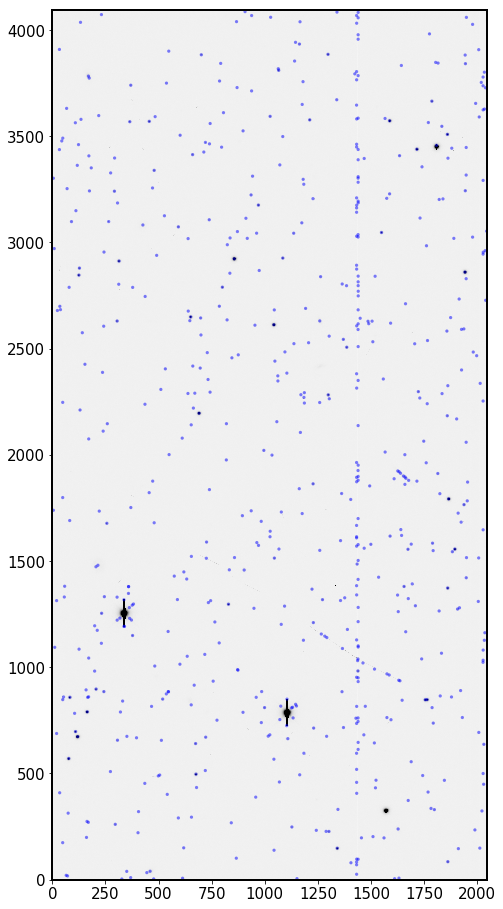

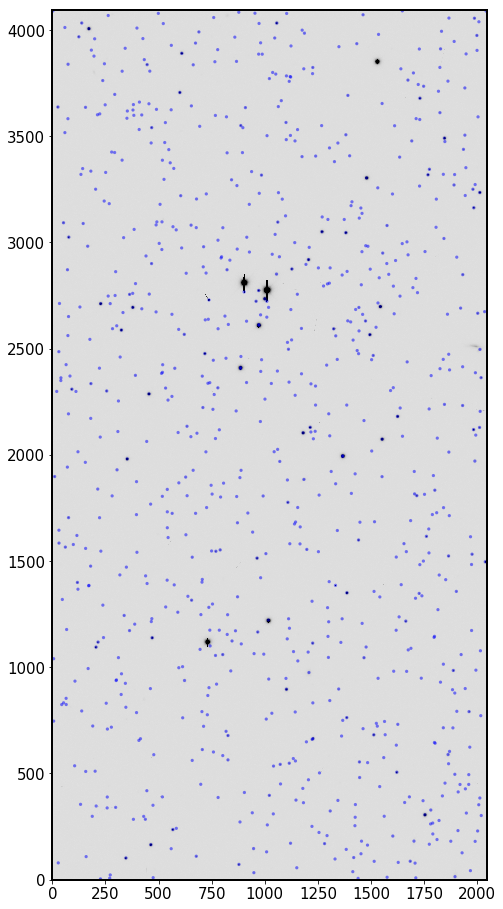

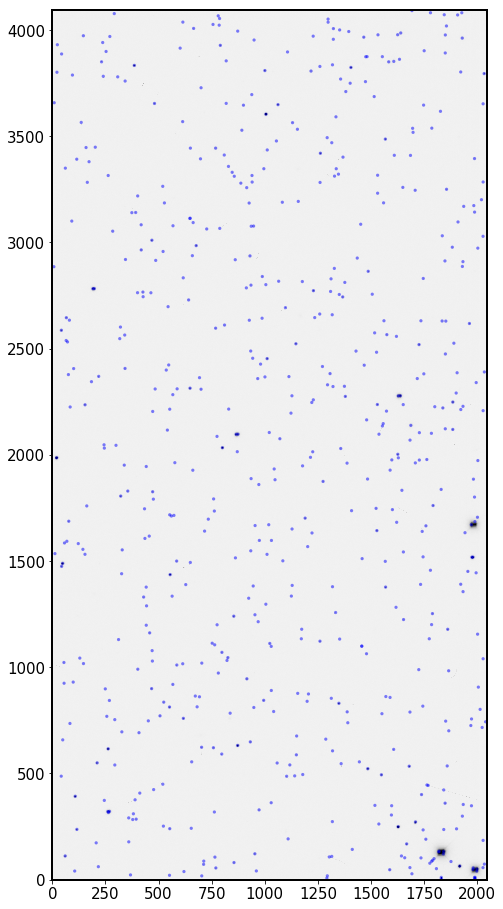

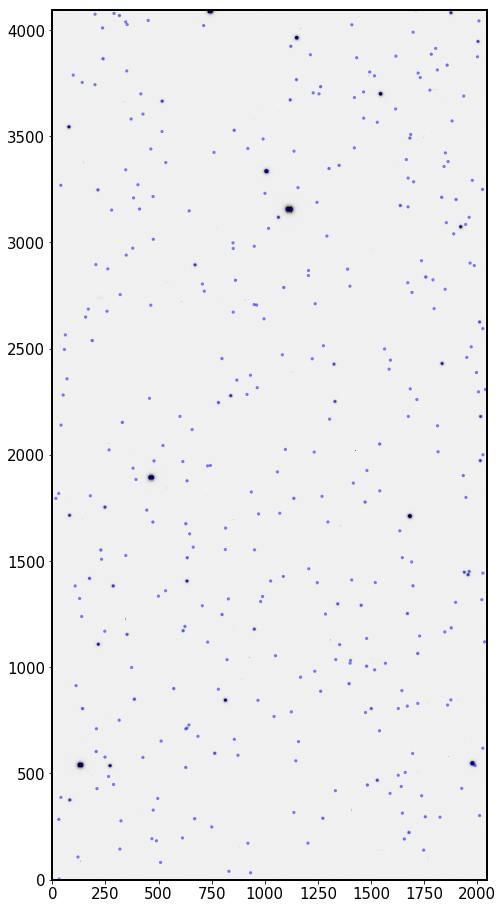

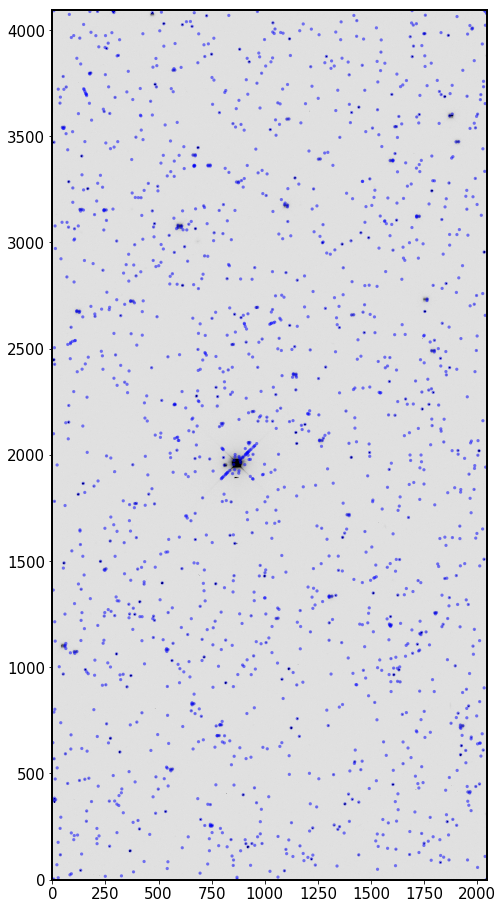

In [353]:
res_dic = {'archive_file':[], 'area_sq_deg':[],
             'fwhm': [],  'threshold':[], 'sources':[],
              'source_density':[]}

# Run DAOStarFinder for all DECam fields 
# we want to check 
for j in range(len(sampled_objects)) :
    fname =  np.array(sampled_objects['archive_file']).astype(str)[j]
    results = count_sources(fname)
    for key in results.keys():
        res_dic[key].append(results[key])
        
#Save the results of counting...
Table(res_dic).write('DAO_'+str(percent)+'_perc_DECam_MAF_counts.csv')

In [354]:
# Display the results...
print(percent)
Table.read('DAO_'+str(percent)+'_perc_DECam_MAF_counts.csv')


0.51


archive_file,area_sq_deg,fwhm,threshold,sources,source_density
str34,float64,float64,float64,int64,float64
c4d_160607_025052_ooi_g_v1.fits.fz,0.0471168225,6.117483,31.5070427428,630,13371.0205097
c4d_170718_042438_ooi_r_v1.fits.fz,0.0471168225,5.847024,54.0614157019,830,17615.7889255
c4d_150615_005257_ooi_g_v1.fits.fz,0.0471168225,5.475378,31.0363521064,608,12904.095984
c4d_150614_002629_ooi_g_v1.fits.fz,0.0471168225,8.060747,31.453033182,366,7767.92620088
tu2046406.fits.fz,0.0471168225,4.202916,55.1179480827,1695,35974.4123238


In [360]:
hdu[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 2046 / Axis length                                    
NAXIS2  =                 4094 / Axis length                                    
PCOUNT  =                    0 / No 'random' parameters                         
GCOUNT  =                    1 / Only one group                                 
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
EXTNAME = 'S29     '           / Extension name                                 
EXTVER  =                    1 / Extension version                              
IRAF-TLM= '2014-07-02T02:56:39' / Time of last modification                     
INHERIT =                    T / Inherits global header                         
DATE    = '2014-07-02T02:56:

### Step-by-step DAO Star Finding....

hdu stores  a mosaic of CCD images. hdu[0] contains  generic information about all images in the mosaic, whereas each following hdu  (hdu[1], hdu[2], etc) contains an image. 

In [141]:
#Display the main header : 
#hdu[0].header    

So from here I know that the scale 0.27 arcsec / px in both directions. Now, there are many image elements, they are called CompImageHDU.


In [135]:
#hdu.info()

In [142]:
# Display the image header 
#hdu[1].header

From that, I found that there are  2046x4094 pixels in each mosaic element.

In [149]:
x_px_scale = hdu[0].header['PIXSCAL1']  # arcsec / pixel
y_px_scale = hdu[0].header['PIXSCAL2']
x_n_pixels = hdu[1].header['NAXIS1']
y_n_pixels = hdu[1].header['NAXIS2']
x_arcsec = x_n_pixels * x_px_scale
y_arcsec = y_n_pixels * y_px_scale
print('Image size in arcmin is %f by %f'%(x_arcsec / 60, y_arcsec / 60 ))
area_size_sq_arcsec = x_arcsec * y_arcsec
area_size_sq_deg = area_size_sq_arcsec / (3600 * 3600)
print('Single image frame area is %d arcsec, i.e. %f sq.deg.' %(area_size_sq_arcsec, 
                                                    area_size_sq_deg ))

Image size in arcmin is 9.207000 by 18.423000
Single image frame area is 610634 arcsec, i.e. 0.047117 sq.deg.


In [83]:
# NOAO Image data structure 
# http://iraf.noao.edu/projects/ccdmosaic/imagedef/imagedef.html#4.1
# https://fits.gsfc.nasa.gov/fits_primer.html 
# http://www.cv.nrao.edu/~aleroy/pytut/topic2/intro_fits_files.py
# http://datalab.noao.edu/notebooks/web/Data_Lab_Interface_Introduction.html 
# Display the informaiton ... 
#hdu.info()

Display the first mosaic element, the same that by default is shown in ds9 

Plotting the histogram of all pixel values helps decide how to stretch the scale : 

In [137]:
#px_value = image_data.flatten()
#plt.hist(px_value[px_value<4000])

In [143]:
# Show the first mosaic element : 
#h =1
#image_data = hdu[h].data
#fig,ax = plt.subplots(1,1,figsize = (6,12))
#ax.imshow(image_data, cmap='Greys', origin='lower', norm=norm, vmin= 600, vmax = 4000)


Perform source detection on the first mosaic region. To do that we need to set the FWHM, and the threshold for detection : kwargs  (fwhm=3.0, threshold=5.*std)    

In [150]:
fwhm = hdu[1].header['FWHM'] # Median FWHM in pixels 
print('The median FWHM is %f pixels'%fwhm)

The median FWHM is 4.179558 pixels


Min: 670.114
Max: 53720.5
Mean: 948.737
Stdev: 632.014
Sigma clipped mean: 857.137450
Sigma clipped median: 848.287109
Sigma clipped stdev: 36.993466
We set the threshold to 5 times the standard deviation of pixel value, i.e. 184.967328 
N sources here is 23500


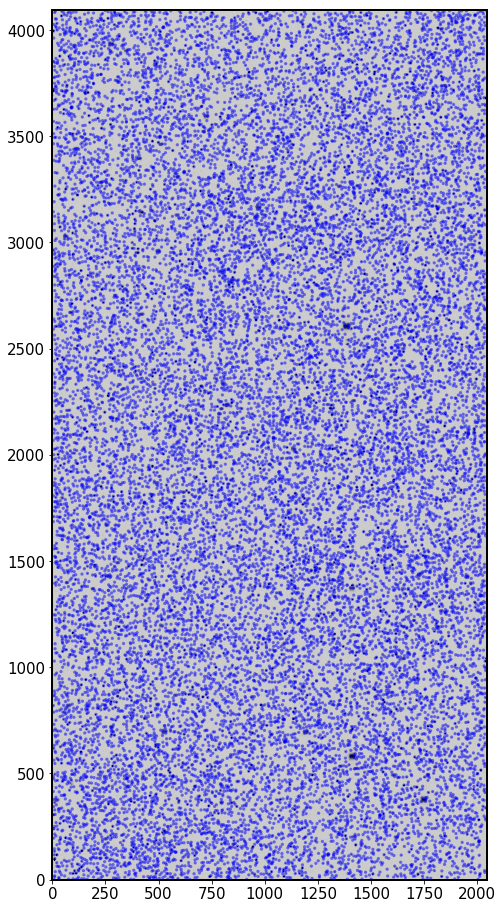

In [151]:
# http://www.astropy.org/astropy-tutorials/FITS-images.html 
# use the first layer, or whatever it is ..... 
# could it be like just one amplifier ? 
h =1
subregion = False 
if subregion : 
    image_data = hdu[h].data[:200,:200]
else:
    image_data = hdu[h].data
    
import numpy as np
print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))


# I fear this works,  but it is just one frame...
mean, median, std = sigma_clipped_stats(image_data, sigma=3.0, iters=5) 

print('Sigma clipped mean: %f'%mean)
print('Sigma clipped median: %f'%median)
print('Sigma clipped stdev: %f'%std)

# set the detection threshold at 5 sigma 
threshold = 5 * std
print('We set the threshold to 5 times the standard deviation \
of pixel value, i.e. %f '%threshold)

# initialize DAOStarFinder Class instance 
daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold)    

# run the source detection 
sources = daofind(image_data - median)    
print('N sources here is %d'%len(sources))

positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch=SqrtStretch())
    
fig,ax = plt.subplots(1,1,figsize = (8,16))
ax.imshow(image_data, cmap='Greys', origin='lower', norm=norm, vmax = 7000, 
          vmin = threshold)
apertures.plot(color='blue', lw=1.5, alpha=0.5)
if subregion : 
    plt.savefig(fname[:-5]+'_'+str(h)+'_sub_200x200_px.png', bbox_inches='tight')
else:
    plt.savefig(fname[:-5]+'_'+str(h)+'.png', bbox_inches='tight')

Looks good! Convert the source density from the size of the image to the counts /  sq.deg. :  

In [153]:
if subregion  : 
    x_arcsec = 200 * x_px_scale
    y_arcsec = 200 * y_px_scale
    area_size_sq_arcsec = x_arcsec * y_arcsec
    area_size_sq_deg = area_size_sq_arcsec / (3600 * 3600)


source_density =  len(sources) / area_size_sq_deg # in sources / sq.deg
print('Source density is %f srcs / sq.deg.'%source_density)

Source density is 498760.288854 srcs / sq.deg.


| percentage | decam ra | decam dec | maf count 
----|---|

## Aside : Check the input from TRILEGAL  : 

It works : below are the trial-and-errors.. Finally I had to resolve to using python 2.7,  
    because mechanize was indeed the best,  but is not supported in python 3.... 

['1']

In [254]:
# RoboBrowser

import re
from robobrowser import RoboBrowser
browser = RoboBrowser(history=True)
browser.open('http://stev.oapd.inaf.it/cgi-bin/trilegal')
form = browser.get_forms()[0]
# form['gal_coord'].options would display options 
# form['gal_coord'].value displays value...

form['gal_coord'].value = '2'
form['eq_alpha'].value = ["277.981111"]
form['eq_delta'].value = ["-19.0833"]
form['field'].value = [" 0.047117"]
form['photsys_file'].value = ["tab_mag_odfnew/tab_mag_lsst.dat"]
form["icm_lim"].value = ["3"]
form["mag_lim"].value = ["24.5"]  

res = browser.submit_form(form)

print(res.parsed)

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/chris/anaconda3/envs/py36/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


ValueError: Option 2 not found in field <robobrowser.forms.fields.Radio object at 0x1437eb6a0>

In [186]:
# pure urllib... 

import urllib.parse
import urllib.request

url = 'http://stev.oapd.inaf.it/cgi-bin/trilegal'
values = {'gal_coord':"2",
            'eq_alpha':"277.981111",
            'eq_delta':"-19.0833",
            'field':" 0.047117",
            'photsys_file':"tab_mag_odfnew/tab_mag_lsst.dat",
            "icm_lim":"3",
            "mag_lim":"24.5"}

data = urllib.parse.urlencode(values)
data = data.encode('ascii') # data should be bytes
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as response:
    the_page = response.read()

In [220]:
#http://docs.grablib.org/en/latest/grab/response_search.html
from grab import Grab
g = Grab()
url = 'http://stev.oapd.inaf.it/cgi-bin/trilegal'
g.go(url)
# display all default form values...
# g.doc.form.form_values()

g.doc.set_input('gal_coord',"2")
g.doc.set_input('eq_alpha',"277.981111")
g.doc.set_input('eq_delta',"-19.0833")
g.doc.submit()

In [261]:
# pure requests

import requests
url = 'http://stev.oapd.inaf.it/cgi-bin/trilegal'
values = {'gal_coord':"2",
            'eq_alpha':"277.981111",
            'eq_delta':"-19.0833",
            'field':" 0.047117",
            'photsys_file':"tab_mag_odfnew/tab_mag_lsst.dat",
            "icm_lim":"3",
            "mag_lim":"24.5"}

r_in = requests.post(url, files = values)

# In case you want to see the see the output html page use the code below.
#html = r.content
#print(html)
#r.status
#r = requests.get('http://stev.oapd.inaf.it/cgi-bin/trilegal_1.6')

In [193]:
import urllib
form_data = {'gal_coord':"2",
            'eq_alpha':"277.981111",
            'eq_delta':"-19.0833",
            'field':" 0.047117",
            'photsys_file':"tab_mag_odfnew/tab_mag_lsst.dat",
            "icm_lim":"3",
            "mag_lim":"24.5"}
params = urllib.parse.urlencode(form_data)
response = urllib.request.urlopen(url, params)
data = response.read()

TypeError: POST data should be bytes, an iterable of bytes, or a file object. It cannot be of type str.

In [158]:
# this would work if mechanize was supported in Python 3 ... 
import re
from mechanize import Browser

browser = Browser()
browser.open("http://stev.oapd.inaf.it/cgi-bin/trilegal")
browser.select_form(nr=0)
browser['gal_coord'] = ["2"]
browser['eq_alpha'] = ["277.981111"]
browser['eq_delta'] = ["-19.0833"]
browser['field'] = [" 0.047117"]
browser['photsys_file'] = ["tab_mag_odfnew/tab_mag_lsst.dat"]
browser["icm_lim"] = ["3"]
browser["mag_lim"] = ["24.5"]                                     
# type="submit" ,  name = "submit_form",  value = "Submit"
response = browser.submit()

content = response.read()


ModuleNotFoundError: No module named 'mechanize'

In [267]:
# mechanical soup...
import mechanicalsoup
browser = mechanicalsoup.Browser()
URL ="http://stev.oapd.inaf.it/cgi-bin/trilegal"
login_page = browser.get(URL)
form = login_page.soup.find("form")
form.select['gal_coord']

In [159]:
# https://stackoverflow.com/questions/12385179/how-to-send-a-multipart-form-data-with-requests-in-python 
# Use that 
import requests
from requests_toolbelt.multipart.encoder import MultipartEncoder

multipart_data = MultipartEncoder(
    fields={'gal_coord':"2",
            'eq_alpha':"277.981111",
            'eq_delta':"-19.0833",
            'field':" 0.047117",
            'photsys_file':"tab_mag_odfnew/tab_mag_lsst.dat",
            "icm_lim":"3",
            "mag_lim":"24.5"
           }
                                 )

response = requests.post("http://stev.oapd.inaf.it/cgi-bin/trilegal", 
                         data=multipart_data,
                  headers={'Content-Type': multipart_data.content_type})


It's not needed because I limit TRILEGAL output to LSST r < 24.5 , so in theory it should give me identical results to MAF ... 

In [ ]:

DirIn = '../raw_data/TRILEGAL/'
fname = DirIn + 'output740009335176.dat'
tri = Table.read(fname, format='ascii')

# this was an area corresponding to the DECam coordinates of 
# image c4d_140624_081148_ooi_r_v2.fits.fz
# selecting the image area just like that of DECam, i.e. 
# 0.047117  square degrees 

for f in 'ugriz' : 
    plt.hist(tri['DECAM'+f].data, bins=40, histtype='step', label=f)
plt.legend()

N_in_CCD = np.sum(tri['DECAMr'].data < 24.5)
source_density =  N_in_CCD  / area_size_sq_deg
source_density

from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

%matplotlib inline
fig,ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(tri['DECAMu']- tri['DECAMg'], tri['DECAMg']-tri['DECAMr'],s=1)
ax.set_xlabel('u-g')
ax.set_ylabel('g-r')

### Notes about sigma_clipped_stats()

Useful for later  : how to display  coordinates of the data ..
     http://docs.astropy.org/en/stable/visualization/wcsaxes/overlays.html 